# Проектная работа. Принятие решений в бизнесе.

### Описание проекта
#### Контекст

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

### Описание данных

Данные для первой части
Файл `hypothesis.csv`
* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.  

Данные для второй части
Файл `orders.csv`
* `transactionId` — идентификатор заказа;
* `visitorId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

Файл `visitors.csv`
* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста


## Предобработка данных <a id="iz"></a> 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
# стили
sns.set_style('whitegrid')

class color:
    BOLD = '\033[1m'
    END = '\033[0m'

In [3]:
def extract(s):
    return pd.read_csv(
        'https://docs.google.com/spreadsheets/d/{}/export?format=csv'
        .format(s)
    )

def df_info(data):
    name = [_ for _ in globals() if globals()[_] is data][1]
    table_info = (
        pd.DataFrame(
            {
                'column_type':data.dtypes,
                'row_count':data.count(),
                'unique_count':data.nunique(),
                'duplicated_count':data.duplicated().sum(),
                'duplicated_pct':data.duplicated().mean(),
                'nan_count':data.isna().sum(),
                'nan_pct':data.isna().mean(),
                'min':data.min(),
                'max':data.max(),
                'mean':data.mean(numeric_only=True)
            }
        )
        .sort_values(by='nan_count',ascending=False)
        .style.format(
            {
                'unique_pct': '{:.1%}',
                'duplicated_pct': '{:.1%}',
                'nan_pct': '{:.1%}',
            }
        )
    )
    return (print(color.BOLD + '- {}'.format(name) + color.END),
            display(table_info))

In [4]:
spreadsheets = {
    'hypothesis': '1dHJfxG0WsywHSNrqjfZ0SLGiE8Aw2uVHN_EX1evXyCo',
    'orders': '1jCLjuJCf59aWxZWL1Vaipv9vip6sO83ImQ8nrWe7bds',
    'visitors': '1NFKWrOY2jMbuZUDTUhAeQMPx8DNc306s2hpaT_4i3dY',
}

hypothesis = extract(spreadsheets['hypothesis'])
orders = extract(spreadsheets['orders'])
visitors = extract(spreadsheets['visitors'])

In [5]:
for _ in (orders,visitors):
    df_info(_) 

- orders


,column_type,row_count,unique_count,duplicated_count,duplicated_pct,nan_count,nan_pct,min,max,mean
date,object,1197,31,0,0.0%,0,0.0%,2019-08-01,2019-08-31,nan
group,object,1197,2,0,0.0%,0,0.0%,A,B,nan
revenue,int64,1197,713,0,0.0%,0,0.0%,50,1294500,8348.005848
transactionId,int64,1197,1197,0,0.0%,0,0.0%,1062393,4293855558,2155621385.529657
visitorId,int64,1197,1031,0,0.0%,0,0.0%,5114589,4283872382,2165960143.099415


- visitors


,column_type,row_count,unique_count,duplicated_count,duplicated_pct,nan_count,nan_pct,min,max,mean
date,object,62,31,0,0.0%,0,0.0%,2019-08-01,2019-08-31,nan
group,object,62,2,0,0.0%,0,0.0%,A,B,nan
visitors,int64,62,58,0,0.0%,0,0.0%,361,770,607.290323


In [6]:
orders = orders.rename({'transactionId':'transaction_id','visitorId': 'visitor_id'}, axis=1)
orders['date'] = pd.to_datetime(orders.date,format='%Y-%m-%d')
visitors['date'] = pd.to_datetime(visitors.date,format='%Y-%m-%d')

Данные корректны. Выборка за 1 месяц.

## Часть 1. Приоритизация гипотез. <a id="chp1"></a> 

In [7]:
pd.set_option('display.max_colwidth', None)

#### 1. Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [8]:
hypothesis['ICE'] = hypothesis.Impact * hypothesis.Confidence / hypothesis.Efforts
hypothesis.sort_values(by='ICE',ascending=False).round(1)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


Перспективные гипотезы по **ICE**: 0,7,8

#### 2. Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [9]:
hypothesis['RICE'] = round(hypothesis.Reach * hypothesis.Impact * hypothesis.Confidence / hypothesis.Efforts,1)
hypothesis.sort_values(by='RICE',ascending=False).round(1)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


Перспективные гипотезы по **RICE**: 2,6,7

#### 3. Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

Приоритет по фреймворку **RICE** учитывает охват пользователей (Reach), топ-3 приоритизаций гипотез для двух методов различен, оптимальным вариантом для двух метрик осталась гипотеза 7.

## Часть 2. Анализ A/B-теста. <a id="chp2"></a> 

In [10]:
print(
    'Количество пользователей в друх группах: {}'
    .format(orders
            .groupby(['visitor_id'])
            .agg({'group': 'nunique'})
            .query('group > 1')
            .reset_index()['visitor_id']
            .count())
)

Количество пользователей в друх группах: 58


#### 1. Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

Доля покупателей в группах:

In [11]:
grp_info = orders.groupby('group').agg({'visitor_id':'nunique'}).rename(columns={'visitor_id':'buyers'})
grp_info['percent'] = grp_info.buyers / orders.group.shape[0]
grp_info.style.format({'percent':'{:.2%}'})

,buyers,percent
group,,
A,503,42.02%
B,586,48.96%


Кумулятивные данные по дням:

In [12]:
# кумулятивные по дням данные о заказах
dates_groups = orders[['date','group']].drop_duplicates()
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg(
        {
            'date' : 'max',
            'group' : 'max', 
            'transaction_id' :'nunique', 
            'visitor_id' : 'nunique', 
            'revenue' : 'sum'})
    ,axis=1).sort_values(by=['date','group'])

# кумулятивные по дням данные о посетителях
visitors_aggregated = (visitors
                       .groupby(['date','group'])
                       .agg({'visitors': 'sum'})
                       .groupby('group')
                       .cumsum()
                       .sort_values(by=['date','group'])
                       .reset_index()
                      )

# объединение кумулятивных данных
cumulative_data = (orders_aggregated
                   .merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']))
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeRevenueA = cumulative_data.query('group == "A"')[['date','revenue', 'orders']]
cumulativeRevenueB = cumulative_data.query('group == "B"')[['date','revenue', 'orders']]

cumulative_data

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


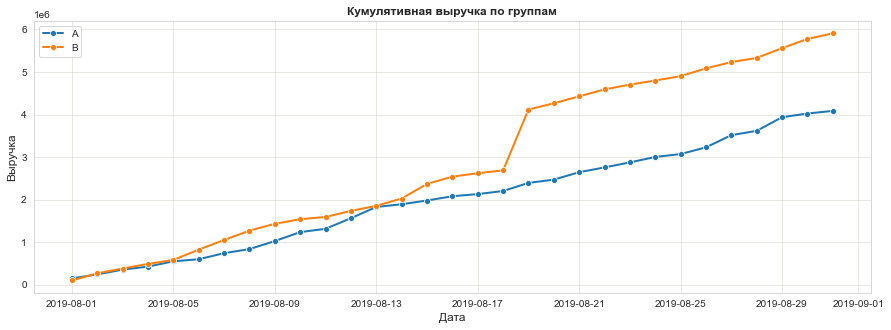

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
527,1570513684,2837914161,2019-08-19,33405,B
461,2683113224,154576532,2019-08-19,26550,B


In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(
    data=cumulativeRevenueA,x=cumulativeRevenueA.date,
    y='revenue',marker='o',linewidth = 2,label = 'A')

sns.lineplot(
    data=cumulativeRevenueB,x=cumulativeRevenueB.date,
    y='revenue',marker='o',linewidth = 2,label = 'B')

ax.grid(True, color='#cfcfc4', alpha=0.6)
ax.legend()
ax.set_title('Кумулятивная выручка по группам',fontweight="bold",fontsize=12)
ax.set_xlabel('Дата', fontsize=12)
ax.set_ylabel('Выручка',fontsize=12)
plt.show()
orders.query('date == "2019-08-19" & group == "B"').sort_values(by='revenue',ascending=False).head(3)

Группа **B** в целом лидирует по росту выручки за этот месяц, 19 августа в группе **B** имеется резкий рост за счет крупного заказа на 1294500.

#### 2. Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

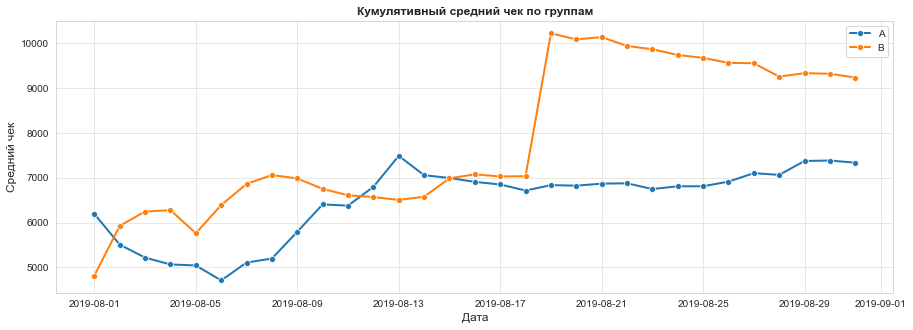

In [14]:
cumulativeRevenueA['mean_check'] = cumulativeRevenueA['revenue']/cumulativeRevenueA['orders']
cumulativeRevenueB['mean_check'] = cumulativeRevenueB['revenue']/cumulativeRevenueB['orders']

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(
    data=cumulativeRevenueA,x=cumulativeRevenueA.date,
    y=cumulativeRevenueA.mean_check,marker='o',linewidth = 2,label = 'A')

sns.lineplot(data=cumulativeRevenueB,x=cumulativeRevenueB.date,
             y=cumulativeRevenueB.mean_check,marker='o',linewidth = 2,label = 'B')

ax.grid(True, color='#cfcfc4', alpha=0.6)
ax.legend()
ax.set_title('Кумулятивный средний чек по группам',fontweight="bold",fontsize=12)
ax.set_xlabel('Дата',fontsize=12)
ax.set_ylabel('Средний чек',fontsize=12)
plt.show()

Кумулятивный средний чек за месяц для группы **B** в целом выше во все дни кроме 12-14 августа, в эти дни имеется просадка относительно группы **A**, во второй половине месяца после скачка 19 августа имеется снижение роста для группы **B**.

#### 3. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

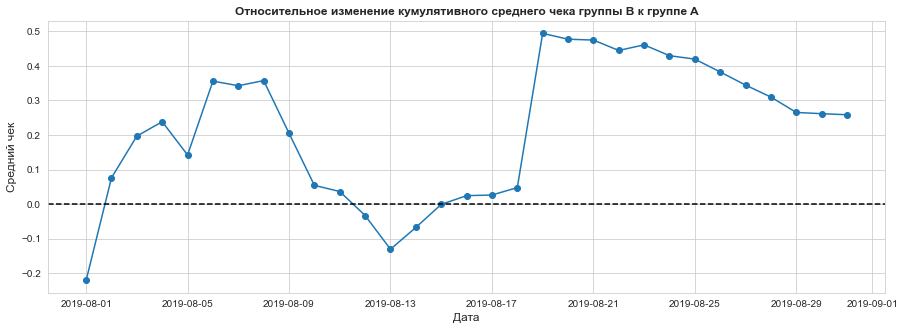

In [15]:
mergedCumulativeRevenue = (
    cumulativeRevenueA
    .merge(cumulativeRevenueB,left_on='date',right_on='date',how='left',suffixes=['A','B'])
)

fig, ax = plt.subplots(figsize=(15, 5))

plt.plot(
    mergedCumulativeRevenue['date'],
    (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])\
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1,marker='o')

plt.axhline(y=0, color='black', linestyle='--') 
ax.set_title(
    'Относительное изменение кумулятивного среднего чека группы B к группе A',
    fontweight="bold",fontsize=12)
ax.set_xlabel('Дата',fontsize=12)
ax.set_ylabel('Средний чек',fontsize=12)
plt.show()

Рост в первой половине месяца, постепенная просадка до 13 августа, дальнейший рост и скачок 19 числа с последующим снижением кумулятивного среднего чека группы **B**.

#### 4. Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

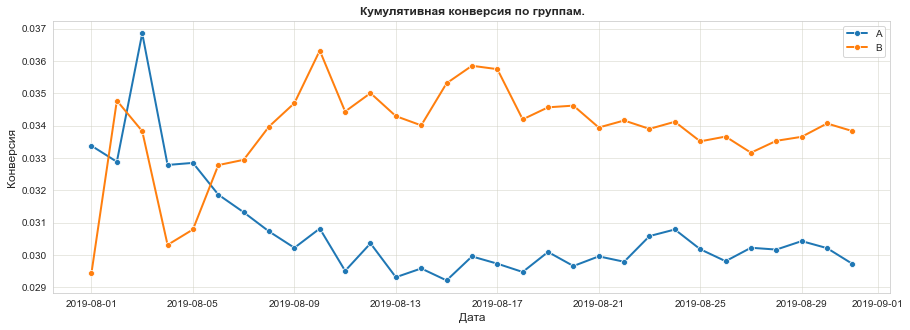

In [16]:
cumulative_data['conversion']=cumulative_data.orders/cumulative_data.visitors
cumulative_data_A = cumulative_data.query('group == "A"')
cumulative_data_B = cumulative_data.query('group == "B"')

fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
    data=cumulative_data_A,x=cumulative_data_A.date,
    y=cumulative_data_A.conversion,marker='o',linewidth = 2,label = 'A')

sns.lineplot(data=cumulative_data_B,x=cumulative_data_B.date,
             y=cumulative_data_B.conversion,marker='o',linewidth = 2,label = 'B')

ax.grid(True, color='#cfcfc4', alpha=0.6)
ax.set_title('Кумулятивная конверсия по группам.',fontweight="bold",fontsize=12)
ax.set_xlabel('Дата',fontsize=12)
ax.set_ylabel('Конверсия',fontsize=12)
ax.legend()
plt.show()

Начальный скачок конверсии в группе **A** с последущим снижением, далее конверсия стабильно держится в диапазоне 0,029-0,031. В группе **B** также имеется скачок в начале месяца, с 9 августа наблюдается рост и удержание в диапозоне 0.033-0.036 до конца месяца. Конверсия для группы **B** больше, чем для группы **A**.

#### 5. Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

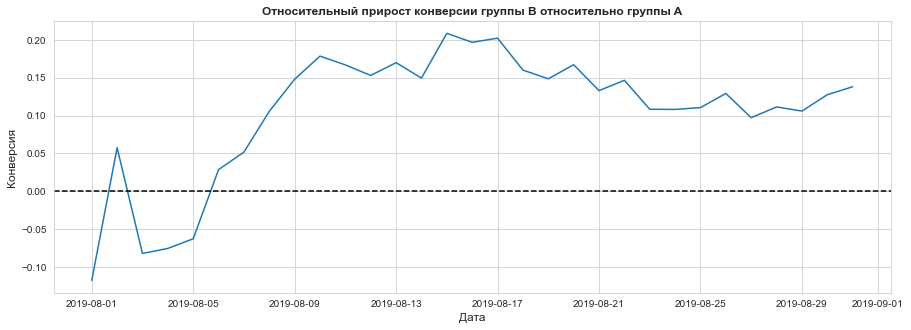

In [17]:
merged_cumulative_conversions = (
    cumulative_data_A[['date','conversion']]
    .merge(
        cumulative_data_B[['date','conversion']],left_on='date',
        right_on='date',how='left', suffixes=['A', 'B']))

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(
    merged_cumulative_conversions['date'],
    merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--') 
ax.set_title(
    'Относительный прирост конверсии группы B относительно группы A',
    fontweight="bold",fontsize=12)
ax.set_xlabel('Дата',fontsize=12)
ax.set_ylabel('Конверсия',fontsize=12)
plt.show()

В начале месяца имеется скачок конверсии 2 августа, дальнейший рост начался с 6 августа до середины месяца(20%), с дальнейшим постепенным снижением конверсии группы **B** в конце периода до 15%. 

#### 6. Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

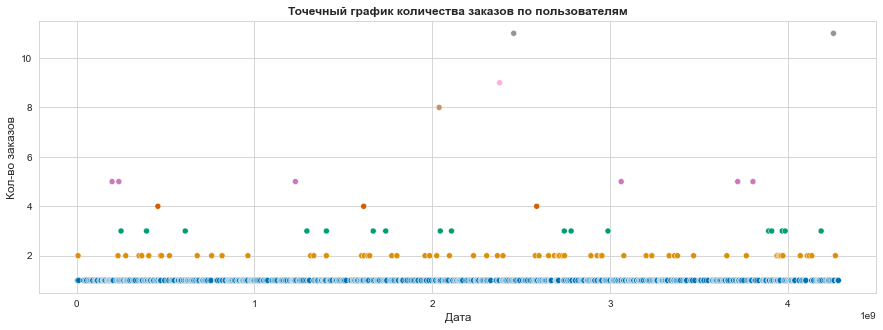

In [18]:
orders_users = orders.groupby('visitor_id',as_index=False).agg({'transaction_id':'nunique'})\
.rename(columns={'transaction_id':'count_orders'})

fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(x='visitor_id',y='count_orders',data = orders_users,hue='count_orders',legend=None,
                palette='colorblind')
ax.set_title('Точечный график количества заказов по пользователям',fontweight="bold",fontsize=12)
ax.set_xlabel('Дата',fontsize=12)
ax.set_ylabel('Кол-во заказов',fontsize=12)
plt.show()

На графике видно, что точек с совершенным 1 заказом больше всего, следом с 2 и 3 заказами. Тех кто совершил более 6 заказов очень мало.

#### 7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [19]:
print(
    '95 процентиль: {}\n99 процентиль: {}'
    .format(
        np.percentile(orders_users.count_orders,[95]),
        np.percentile(orders_users.count_orders,[99])
    )
)

95 процентиль: [2.]
99 процентиль: [4.]


Больше 4 заказов сделали меньше 1% пользователей, за границу аномальных пользователей возьмем 99%.

#### 8. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

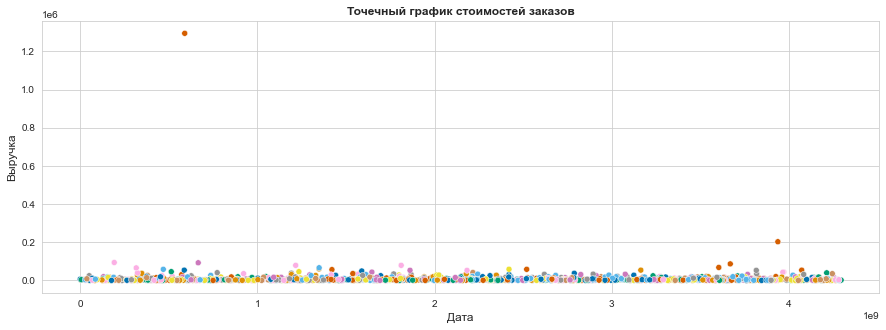

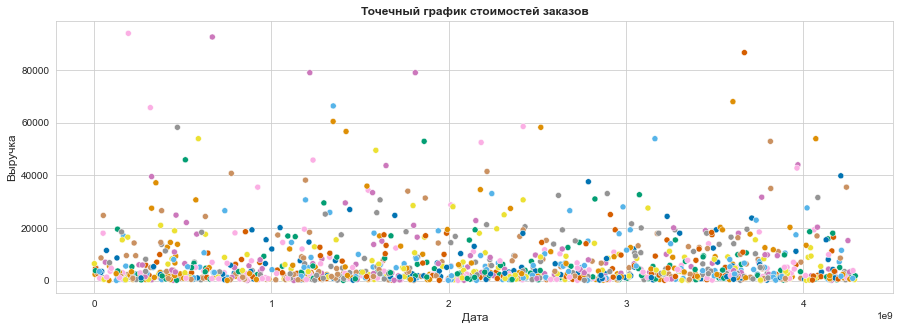

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(
    x='transaction_id',y='revenue',data = orders,
    hue='visitor_id',legend=None,palette='colorblind')

ax.set_title('Точечный график стоимостей заказов',fontweight="bold",fontsize=12)
ax.set_xlabel('Дата',fontsize=12)
ax.set_ylabel('Выручка',fontsize=12)
plt.show()

# revenue <= 200000
fig, ax = plt.subplots(figsize=(15, 5))
sh = orders.query('revenue <= 200000')
sns.scatterplot(
    x=sh.transaction_id,y=sh.revenue,data = sh,
    hue='visitor_id',legend=None,palette='colorblind')

ax.set_title('Точечный график стоимостей заказов',fontweight="bold",fontsize=12)
ax.set_xlabel('Дата',fontsize=12)
ax.set_ylabel('Выручка',fontsize=12)
plt.show()

Основная масса заказов стоимостью до 20000.

#### 9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [21]:
print(
    '95 процентиль: {}\n99 процентиль: {}'
    .format(
        np.percentile(orders.revenue,[95]).round(1),
        np.percentile(orders.revenue,[99]).round(1)
    )
)

95 процентиль: [28000.]
99 процентиль: [58233.2]


Для 99% заказов сумма меньше 58233.2, за границу аномальных пользователей возьмем 99%.

#### Задания 10-14  <a id="chpр"></a> 

Ежедневное количество заказов, сумма выручки, количество визитов для двух групп за месяц:

In [22]:
# A
daily_visits_A = (
    visitors
    .query('group == "A"')[['date', 'visitors']]
    .rename(columns={'visitors':'daily_visitors_A'})
)

daily_orders_A = (
    orders
    .query('group == "A"')[['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id' : 'nunique','revenue' : 'sum'})
    .rename(columns={'transaction_id':'daily_orders_A','revenue': 'daily_revenue_A'})
)

# B
daily_visits_B = (
    visitors
    .query('group == "A"')[['date', 'visitors']]
    .rename(columns={'visitors':'daily_visitors_B'})
)

daily_orders_B = (
    orders
    .query('group == "B"')[['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id' : 'nunique','revenue' : 'sum'})
    .rename(columns={'transaction_id':'daily_orders_B','revenue': 'daily_revenue_B'})
)

# all
df = (
    daily_orders_A
    .merge(daily_visits_A, left_on='date', right_on='date', how='left')
    .merge(daily_orders_B, left_on='date', right_on='date', how='left')
    .merge(daily_visits_B, left_on='date', right_on='date', how='left')
)

df.head()

,date,daily_orders_A,daily_revenue_A,daily_visitors_A,daily_orders_B,daily_revenue_B,daily_visitors_B
0,2019-08-01,24,148579,719,21,101217,719
1,2019-08-02,20,93822,619,24,165531,619
2,2019-08-03,24,112473,507,16,114248,507
3,2019-08-04,16,70825,717,17,108571,717
4,2019-08-05,25,124218,756,23,92428,756


In [23]:
# количество заказов для каждого отдельного юзера
orders_users_A = (
    orders
    .query('group == "A"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
).rename(columns={'transaction_id':'orders_users_A'})

orders_users_B = (
    orders
    .query('group == "B"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
).rename(columns={'transaction_id':'orders_users_B'})

# нули если нет заказов (разница между суммой посетителей и количеством записей о заказах)
grp_A = (
    pd.concat(
        [orders_users_A.orders_users_A,
         pd.Series(
             0, index=np.arange(df.daily_visitors_A.sum() - len(orders_users_A.orders_users_A)
                               ), name='orders')],axis=0))

grp_B = (
    pd.concat(
        [orders_users_B.orders_users_B,
         pd.Series(
             0, index=np.arange(df.daily_visitors_B.sum() - len(orders_users_A.orders_users_A)
                               ), name='orders')],axis=0))

Очистим данные по 99 процентилю, т.е. без учета выручки и количеству заказов больше 99 процентиля, чтобы избавиться от выбросов:

In [24]:
# очистка данных
revenue_99_perc = np.percentile(orders.revenue,99).astype('int')
count_orders_99_perc = np.percentile(orders_users.count_orders,99).astype('int')
                 
id_big_revenue = orders[orders['revenue'] > revenue_99_perc]['visitor_id']
id_big_count = (
    pd.concat(
        [orders_users_A[orders_users_A.orders_users_A > count_orders_99_perc]['visitor_id'],
         orders_users_B[orders_users_B.orders_users_B > count_orders_99_perc]['visitor_id']],
        axis = 0)
)

filter_id = pd.concat(
    [id_big_revenue,id_big_count],axis = 0
).drop_duplicates()

# чистые группы
grp_A_filtered = (
    pd.concat(
        [orders_users_A[np.logical_not(
            orders_users_A['visitor_id'].isin(filter_id))]['orders_users_A'],
         pd.Series(0, index=np.arange(
             df.daily_visitors_A.sum() - len(orders_users_A.orders_users_A)
         ), name='orders')],axis=0))

grp_B_filtered = (
    pd.concat(
        [orders_users_B[np.logical_not(
            orders_users_B['visitor_id'].isin(filter_id))]['orders_users_B'],
         pd.Series(0, index=np.arange(
             df.daily_visitors_B.sum() - len(orders_users_B.orders_users_B)
         ), name='orders')],axis=0))

#### 10. Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.

* **H0** - статистически значимых различий в конверсии между группами нет
* **H1** - статистически значимые различия в конверсии между группами есть 

alpha = 0.05

In [25]:
print(
    'p-value = {0:.4f}'
    .format(stats.mannwhitneyu(grp_A, grp_B)[1])
)
print(
    'относительный прирост конверсии группы B = {0:.4f}'
    .format(grp_B.mean()/grp_A.mean()-1)
)

p-value = 0.0132
относительный прирост конверсии группы B = 0.1439


**Вывод:**  
**p-value** меньше 5%, значит **H0** отвергаем, в «сырых» данных мы имеем различия конверсии для наших групп, относительный прирост конверсии группы **B** над группой **A** - 14%.

#### 11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

* **H0** - статистически значимых различий в среднем чеке между группами нет
* **H1** - статистически значимые различия в среднем чеке между группами есть 

In [26]:
revenue_A = orders.query('group == "A"')['revenue']
revenue_B = orders.query('group == "B"')['revenue']

print(
    'p-value = {0:.4f}'
    .format(stats.mannwhitneyu(revenue_A,revenue_B)[1])
)
print(
    'относительная разница среднего чека группы B = {0:.4f}'
    .format(revenue_B.mean()/revenue_A.mean()-1)) 

p-value = 0.7293
относительная разница среднего чека группы B = 0.2587


**Вывод:**  
**p-value** больше 5%, значит **H0** мы не можем отвергнуть, средний чек в двух группах схож. Средний чек группы **B** больше на 26% по отношению к группе **A**.

#### 12. Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.

* **H0** - статистически значимых различий в конверсии между группами в очищенных данных нет
* **H1** - статистически значимые различия в конверсии между группами в очищенных данных есть  

In [27]:
print(
    'p-value = {0:.4f}'
    .format(stats.mannwhitneyu(grp_A_filtered, grp_B_filtered)[1])
)
print(
    'относительный прирост конверсии группы B = {0:.4f}'
    .format(grp_B_filtered.mean()/grp_A_filtered.mean()-1)
)

p-value = 0.0092
относительный прирост конверсии группы B = 0.1644


**Вывод:**  
**p-value** меньше 5%, значит **H0** отвергаем, т.е. в «чистых» данных есть разница. Относительный прирост конверсии группы **B** над группой **A** - 16%.

#### 13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

* **H0** - статистически значимых различий в среднем чеке между группами в очищенных данных нет
* **H1** - статистически значимые различия в среднем чеке между группами в очищенных данных есть 

In [28]:
clean_A_rev = (
    orders[np.logical_and(
        orders.group == 'A',np.logical_not(orders.visitor_id.isin(filter_id)))]['revenue'])

clean_B_rev = (
    orders[np.logical_and(
        orders.group == 'B',np.logical_not(orders.visitor_id.isin(filter_id)))]['revenue'])

print(
    'p-value = {0:.4f}'
    .format(stats.mannwhitneyu(clean_A_rev,clean_B_rev)[1])
)
print(
    'относительная разница среднего чека группы B = {0:.4f}'
    .format(clean_B_rev.mean()/clean_A_rev.mean()-1)
)

p-value = 0.8509
относительная разница среднего чека группы B = -0.0057


**Вывод:**  
**p-value** больше 5%, значит **H0** не отвергаем, т.е. в «чистых» данных есть разница. По «чистым» данным средний чек группы **B** ниже среднего чека группы **A** на пол процента.

#### 14. Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

Сравнение «чистых» и «сырых» данных:

<table border="1" width="100%">
    <thead>
        <tr bgcolor="#f1edf2">
            <th style="text-align:center">Чистые</th>
            <th style="text-align:center">Сырые</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><p>Есть разница в конверсии, относительный прирост конверсии группы <b>B</b> над группой <b>A</b> - 16%.</p></td>
            <td><p>Есть разница в конверсии, относительный прирост конверсии группы <b>B</b> над группой <b>A</b> - 14%.</p></td>
        </tr>
        <tr>
            <td><p>В среднем чеке есть разница. Средний чек группы <b>B</b> ниже среднего чека группы <b>A</b> на пол процента.</p></td>
            <td><p>Средний чек в двух группах схож. Средний чек группы <b>B</b> больше на 26% по отношению к группе <b>A</b>.</p></td>
        </tr>
    </tbody>
</table>

В «сырых» данных средний чек группы **B** больше на 26%, после очистки он меньше на пол процента по отношению к группе **A**.

* Разницу в средних чеках можно считать незначительной.  
* Есть разница в конверсии, группа **B** выигрывает у группы **A**.  


**Можно остановить тест и зафиксировать победу группы B**.